In [1]:
from __future__ import division
import math
import os
import random
import numpy as np
import matplotlib
# # saving high quality figures
# matplotlib.use('agg')
# from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
np.seterr(divide='ignore', invalid='ignore')
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from functools import reduce
%pip install -U --quiet 'gym==0.21.0' 'gym[atari,accept-rom-license]'
import gym
from gym import spaces

In [6]:
class NET(nn.Module):
    # define the networ structure
    def __init__(self, num_input, hidden_units):
        super(NET, self).__init__()
        self.hidden = nn.Linear(num_input, hidden_units[0])
        self.hidden2 = nn.Linear(hidden_units[0], hidden_units[1])
        self.hidden3 = nn.Linear(hidden_units[1], hidden_units[2])
        self.qvalue = nn.Linear(hidden_units[2], 1)
        return

    def forward(self, s, a):
        x = torch.tensor(np.append(s, a), dtype = torch.float).unsqueeze(0)
        x = F.leaky_relu(self.hidden(x))
        x = F.leaky_relu(self.hidden2(x))
        x = F.leaky_relu(self.hidden3(x))
        return self.qvalue(x)


class ZapNN():

    eps = 1e-4              # epsilon used in computing matrix gain G_n
    beta = 1
    gamma = 0.85            # parameter for the second time scale (corresponds to \rho in the paper)
    eps_greedy = 0.1        # epsilon for the epsilon-greedy policy
    
    def __init__(self, env):
        '''Initalize Zap Q-learning agent.'''
        self.net = NET(5, [24, 16, 10]) 
        self.zeta = NET(5, [24, 16, 10])                            # delayed Q-function for computing the eligibility vector
        self.zeta.load_state_dict(self.net.state_dict())
        self.action_n = env.action_space.n
        self.size = sum(p.numel() for p in self.net.parameters())
        print("size is", self.size)
        assert self.size == sum(p.numel() for p in self.net.parameters() if p.requires_grad), "The parameters are not all trainable, check!!! "
        self.Ahat = torch.eye(self.size, requires_grad = False)
        self.A, self.barf = torch.zeros(self.size, self.size, requires_grad = False), torch.zeros(self.size, requires_grad = False)
        self.iter_nums = [0, 0]
        self.ratio, self.lr = 100, 0.005                             # constant step size
        self.block = 50
        return

    def sarsa(self, state, ptype = 'eps'):
        '''Epsilon greedy policy.'''
        if ptype == 'eps':
            if np.random.rand() < self.eps_greedy:
                return np.random.randint(2)
            return self.greedy_act(state)
        else:
            raise NameError('Sarsa type not properly defied yet')
    
    def decide(self, state, strategy):
        '''Behavior policy.'''
        if strategy == 'greedy':
            return self.greedy_act(state)
        elif strategy == 'sarsa':
            return self.sarsa(state, 'eps')
        else:
            raise NameError('Running policy has not been defined yet.')

    def greedy_act(self, nstate):
        '''select the greedy action based on the current value function. This is used for Q-learning update'''
        with torch.no_grad():
            qs = [self.net(nstate, naction) for naction in range(self.action_n)]
            return np.argmax(qs)

    def gradient(self, outputs, inputs, retain_graph=None, create_graph=False):
        grads = torch.autograd.grad(outputs, inputs,
                                allow_unused=True,
                                retain_graph=retain_graph,
                                create_graph=create_graph)
        grads = [x if x is not None else torch.zeros_like(y) for x, y in zip(grads, inputs)]
        return torch.cat([x.contiguous().view(-1) for x in grads])

    def grad_td(self, state, action, state_next, greedy_act, reward, params, done):
        '''
        Compute the gradient of temporal difference error d_{n+1}.
        '''
        self.net.zero_grad()
        output = reward +  (not done) * self.beta * self.net(state_next, greedy_act) - self.net(state, action)
        grads = torch.autograd.grad(output, params)
        grads = torch.cat([x.contiguous().view(-1) for x in grads])
        return grads.detach(), output.item()

        
    def zap_jacob(self, state, action, state_next, reward, done):
        '''
        Compute the jacobian matrix A_n(\theta_n) = f(\theta_n, \Phi_{n+1}) with zeta being delayed.
        '''
        greedy_act = self.greedy_act(state_next)
        params = list(self.net.parameters())
        gd, d = self.grad_td(state, action, state_next, greedy_act, reward, params, done)
        self.zeta.zero_grad()
        zeta = self.gradient(self.zeta(state, action), list(self.zeta.parameters()))
        return torch.ger(zeta, gd), d*zeta.detach()
    
    def learn(self, state, action, reward, state_next, episode, done, ):
        ''' 
        Accumulate the one-step SA update within a block.
        '''
        A, sa_update= self.zap_jacob(state, action, state_next, reward, done)
        self.barf +=  1.0/((self.iter_nums[1] % self.block) + 1.0)*(sa_update - self.barf)  # RAM consuming
        self.A +=  1.0/((self.iter_nums[1] % self.block) + 1.0)*(A  - self.A) # RAM consuming 
        if (self.iter_nums[1] + 1) % self.block == 0:
            # update the parameters of neural network
            self.update(self.iter_nums[1] // self.block, episode, 'ds', 100.0)
        self.iter_nums[1] += 1
        return

    def update(self, block_n, episode, stepsize = 'ds', offset = 1.0):
        '''
        Update the parameters of \haA_n, \theta_n by Zap SA algorithm using accumulated SA updates averages over the last block.
        '''
        if stepsize == 'ds':
            # decreasing step-size
            fast_step = 1.0 - reduce(lambda x, y: x*y, [1.0 - 1.0/math.pow(j + offset, self.gamma) for j in range(self.iter_nums[0], self.iter_nums[1]+1)])
            self.Ahat += fast_step * (self.A - self.Ahat)
            td = - 1.0/(block_n + offset) *torch.solve(torch.mv(self.Ahat.t(), self.barf).view(-1, 1), self.eps*torch.eye(self.size) + torch.mm(self.Ahat.t(), self.Ahat))[0].view(-1)
            self.iter_nums[0] = self.iter_nums[1] + 1
        elif stepsize == 'cs':
            # constant step-size
            self.Ahat +=  self.ratio * self.lr * (self.A - self.Ahat)
            td = - self.lr *torch.solve(torch.mv(self.Ahat.t(), self.barf).view(-1, 1), self.eps*torch.eye(self.size) + torch.mm(self.Ahat.t(), self.Ahat))[0].view(-1)
        else:
            raise NameError('Step size for Zap not recognized.')

        ## update the parameters of neural net
        self._add_grad(td.view(-1), self.net.parameters())
        
        ## clear the temporary gains and barfs accumulated
        self.A.zero_(), self.barf.zero_()

        if (block_n + 1) % 20 == 0:
            # update the function for computing eligibility vector.
            self.zeta.load_state_dict(self.net.state_dict())

        return

    def _add_grad(self, td, params):
        ''' Adding the update to the parameters of the network.'''
        offset = 0
        for p in params:
            numel = p.numel()
            # use p.data such that this operation won't be traced to compute gradients.
            p.data.add_(td[offset:offset + numel].view_as(p.data))
            offset += numel
        assert offset == self.size, "dimension of gradient is different than dimension of parameters." 
        return

def terminal(env):
    ''' determine if the state of system reaches the termination state. The code is based on source code of Cartpole from OpenAI gym.'''
    x, theta = env.state[0], env.state[2]
    done =  x < -env.x_threshold \
                or x > env.x_threshold \
                or theta < -env.theta_threshold_radians \
                or theta > env.theta_threshold_radians
    return done

def play_zap(env, agent, episode, strategy = 'sarsa', train=False, render=True):
    ''' Run Zap algorithm over one episode. '''
    episode_reward = 0
    observation = env.reset()
    action = agent.decide(observation, strategy)
    while True:
        if render:
            env.render()
        observation_next, reward, done, _ = env.step(action)
        episode_reward += reward
        real_done = done
        action_next = agent.decide(observation_next, strategy) 
        if train:
            agent.learn(observation, action, reward, observation_next, episode, real_done)
        # print("I don't think it can run this far 2")
        observation, action = observation_next, action_next
        if done:
            break
    if train and real_done:
        ## real done, instead of just hitting the maximum number of steps
        agent.learn(observation, action, 0, observation_next,episode, real_done)
    return episode_reward, real_done

def test_zap(env, agent, render=True):
    ''' Run simulation following the greedy policy phi^\theta induced by Q^\theta.'''
    episode_reward = 0
    observation = env.reset()
    action = agent.decide(observation, 'greedy')
    while True:
        if render:
            env.render()
        observation_next, reward, done, _ = env.step(action)
        episode_reward += reward
        action_next = agent.decide(observation_next, 'greedy') 
        observation, action = observation_next, action_next
        if done:
            break
    return episode_reward, done


def OneRun(env, args, exp_indx, render, episodes = 10000):
    '''
    Run one simulation for training Zap.
    '''
    seed = exp_indx
    torch.manual_seed(seed)
    np.random.seed(seed)
    env.seed(seed)
    env.reset()
    agent = ZapNN(env)
    policy_rewards = []
    env._max_episode_steps = 1000 ## maximum time step for each episode.

    for episode in range(episodes):
        episode_reward, done = play_zap(env, agent, episode, 'sarsa', train=True, render = False)
        
        if (episode + 1)% 200 == 0:
            ## evaluate the greedy policy phi^\theta induced by Q^\theta.
            print('Playing episodes: {}...ended with steps {}'.format(episode, episode_reward))
            perf_eval = 0.0
            for i in range(100):
                reward, _ = test_zap(env, agent, render)
                perf_eval += 1.0/(i + 1.0)*(reward - perf_eval)
            print('Start testing!... ' + str(perf_eval))
            policy_rewards.append(perf_eval)
    return policy_rewards

def env_wrapper(game, frame_skip_length=4, stack_length=4):
    # create and update the environment
    env = gym.make(game)
    env = NoopResetEnv(env, noop_max=30)
    # original observation space 210 * 160 return max_frame in the _obs_buffer with frame skip 4
    env = MaxAndSkipEnv(env, skip=frame_skip_length)
    # calculate lives and return true done for specific game
    env = EpisodicLifeEnv(env)
    env = FireResetEnv(env)
    # important add function for warp frame to 84*84*1
    env = WarpFrame(env)
    # print(env.observation_space.shape)
    # normlize and change to 1*84*84 shape
    env = PyTorchFrame(env)
    # print(env.observation_space.shape)
    # add reward function to clip reward to -1,0,1
    env = ClipRewardEnv(env)
    # print(env.observation_space.shape)
    # action = 0
    # ob, reward, done, info = env.step(action)
    # print(ob.shape)
    env = FrameStack(env, stack_length)
    # env = gym.wrappers.Monitor(env, './video/', video_callable=lambda episode_id: episode_id % 100 == 0, force=True)
    return env

In [20]:
if __name__ == '__main__':
    episodes = 10000   # overall number of trainning episodes.
    N_SET = 5
    RewardList = np.empty((int(episodes/200), N_SET))
    env = gym.make('CartPole-v0')
    render = False
    result_dir = 'result_dir'
    if not os.path.exists(result_dir):
        os.mkdir('result_dir')

    for i in range(N_SET):
        rewardOfThisRun = OneRun(env, result_dir, i, render, episodes)
        RewardList[:,i] = rewardOfThisRun
    env.close()

size is 725


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:43: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  result = getattr(asarray(obj), method)(*args, **kwds)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


Playing episodes: 199...ended with steps 9.0
Start testing!... 9.440000000000007
Playing episodes: 399...ended with steps 10.0
Start testing!... 9.57
Playing episodes: 599...ended with steps 18.0
Start testing!... 18.35
Playing episodes: 799...ended with steps 16.0
Start testing!... 9.360000000000003
Playing episodes: 999...ended with steps 8.0
Start testing!... 9.3
Playing episodes: 1199...ended with steps 12.0
Start testing!... 9.410000000000004
Playing episodes: 1399...ended with steps 10.0
Start testing!... 9.369999999999997
Playing episodes: 1599...ended with steps 9.0
Start testing!... 9.249999999999996
Playing episodes: 1799...ended with steps 11.0
Start testing!... 9.289999999999996
Playing episodes: 1999...ended with steps 10.0
Start testing!... 9.48
Playing episodes: 2199...ended with steps 9.0
Start testing!... 9.439999999999998
Playing episodes: 2399...ended with steps 9.0
Start testing!... 9.339999999999998
Playing episodes: 2599...ended with steps 10.0
Start testing!... 9

Text(0, 0.5, 'Average eposide reward')

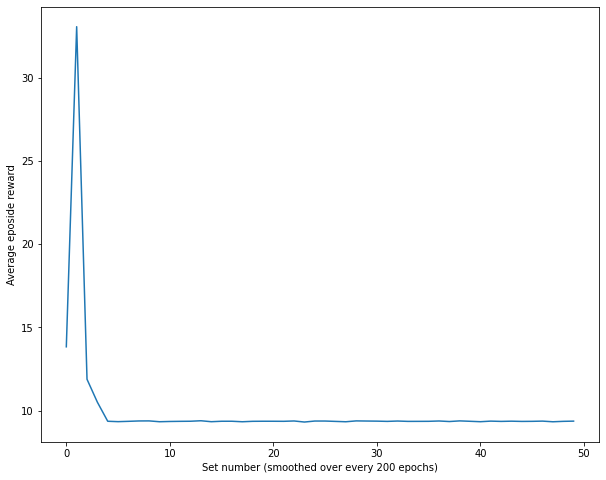

In [19]:
##
%matplotlib inline
plt.figure(figsize=(10,8))
plt.plot(range((int(episodes/200))), np.mean(RewardList, axis=1))
plt.xlabel('Set number (smoothed over every {} epochs)'.format(200))
plt.ylabel('Average eposide reward')